In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np

# Step 1: File upload
file_path_assigned_leads = r"C:\Users\_Lenovo_\Desktop\data-analysis-tasks\assigned_leads (1).xlsx"
file_path_contracted_agents = r"C:\Users\_Lenovo_\Desktop\data-analysis-tasks\contracted_agents (1).xlsx"
file_path_sales_jan_jul = r"C:\Users\_Lenovo_\Desktop\data-analysis-tasks\sales_jan_jul (1).xlsx"

df_assigned_leads = pd.read_excel(file_path_assigned_leads, sheet_name=0, header=0, index_col=None)
df_contracted_agents = pd.read_excel(file_path_contracted_agents, sheet_name=0, header=0, index_col=3)
df_sales_jan_jul = pd.read_excel(file_path_sales_jan_jul, sheet_name=0, header=0)

We have 304 valid agents from the contracted_agents file and 881 unique logins in the sales_jan_jul file. Let's start with a general overview of the sales data — a summary table of sales and leads. Then we’ll move on to analyzing agents for whom we have information.

In [3]:
# Get describe without 'Ticket Issuing Date'
df_sales_jan_jul_describe = df_sales_jan_jul.drop(columns='Ticket Issuing Date').describe()

# Add the column Leads Taken from another describe — by rows (axis=1)
df_sales_jan_jul_describe['Leads Taken'] = df_assigned_leads['Leads Taken'].describe()
df_sales_jan_jul_describe = df_sales_jan_jul_describe.drop(index='count')
df_sales_jan_jul_describe

,Total profit,Sales Count,Leads Taken
mean,6.152326,1.223072,212.995421
std,8.344309,0.558375,247.285363
min,-5.569839,1.000000,1.000000
25%,1.418392,1.000000,33.000000
50%,3.782100,1.000000,134.000000
75%,7.674975,1.000000,316.000000
max,140.127120,15.000000,4652.000000


In the table above, Leads Taken reflects the number of leads received on average by an agent per month (based on the assigned_leads file). On the other hand, the metrics Total profit and Sales Count are daily averages per agent — calculated only for the days when the agent made at least one sale. Days without any sales are not considered.

If we take into account all days in the sales_jan_jul table from 01.01.2024 to 31.07.2024, including days with no sales, then **on average, each agent makes about 0.05 sales per day and earns $0.26 in profit per day**.

You can also see that the median (50th percentile) and the maximum in the Leads Taken column differ significantly. This indicates an uneven distribution of leads. And there is a **clear outlier — the row "va380, 2024-05" with a "Leads Taken" value of 4652**, with the next highest values being 2957 and 2499. After that, the values decline more gradually.

Let’s highlight the top 10 agents by number of sales and the bottom 10 with the lowest results.

In [4]:
sales_by_login = df_sales_jan_jul.groupby('Login')['Sales Count'].sum().sort_values(ascending=False)

from IPython.display import display, HTML

top_10 = pd.DataFrame(sales_by_login).head(10)
bottom_10 = pd.DataFrame(sales_by_login).tail(10)

html = f"""
<div style="display: flex; gap: 40px;">
  <div>
    <h3>Top 10</h3>
    {top_10.to_html()}
  </div>
  <div>
    <h3>Bottom 10</h3>
    {bottom_10.to_html()}
  </div>
</div>
"""

display(HTML(html))


,Sales Count
Login,
am212,103
vk659,99
ap168,81
np100,81
mb151,80
em142,80
sm1123,74
ak124,72
gg100,71


Below is a table showing the top 10 agents who received the most leads and the bottom 10 with the fewest received leads.

In [5]:
Leads_Taken_by_login = df_assigned_leads.groupby('Login')['Leads Taken'].sum().sort_values(ascending=False)
from IPython.display import display, HTML

top_10 = pd.DataFrame(Leads_Taken_by_login).head(10)
bottom_10 = pd.DataFrame(Leads_Taken_by_login).tail(10)

html = f"""
<div style="display: flex; gap: 40px;">
  <div>
    <h3>Top 10</h3>
    {top_10.to_html()}
  </div>
  <div>
    <h3>Bottom 10</h3>
    {bottom_10.to_html()}
  </div>
</div>
"""

display(HTML(html))

,Leads Taken
Login,
vr209,11004
va380,8301
ak1020,6887
hm339,6297
mg524,6071
ss5550,5772
jp246,5532
bo117,5202
al448,5029


It’s also worth noting that **none of the top 10 agents by sales appear in the top 10 by received leads**. The first overlap is the 9th-ranked sales agent “gg100,” who ranks 162nd in terms of received leads out of 2436 agents who received at least some leads.

In the sales table, there are 13 logins that do not appear in the lead assignment table. Out of 881 logins in sales_jan_jul, only 868 are present in assigned_leads. Presumably, some agents received leads before the first date in assigned_leads, or there is a data error. Nevertheless, if we calculate the number of leads required for a single sale using this data, **on average, 133 leads are needed to make one sale, which typically generates $5 in profit (Total profit)**.

In [55]:
print(df_assigned_leads['Leads Taken'].sum() / df_sales_jan_jul['Sales Count'].sum())
print(df_sales_jan_jul['Total profit'].sum() / df_sales_jan_jul['Sales Count'].sum())

133.11085205595592
5.0302243187626114


Let’s look at the overall distribution of sales — how many agents made a certain number of sales.

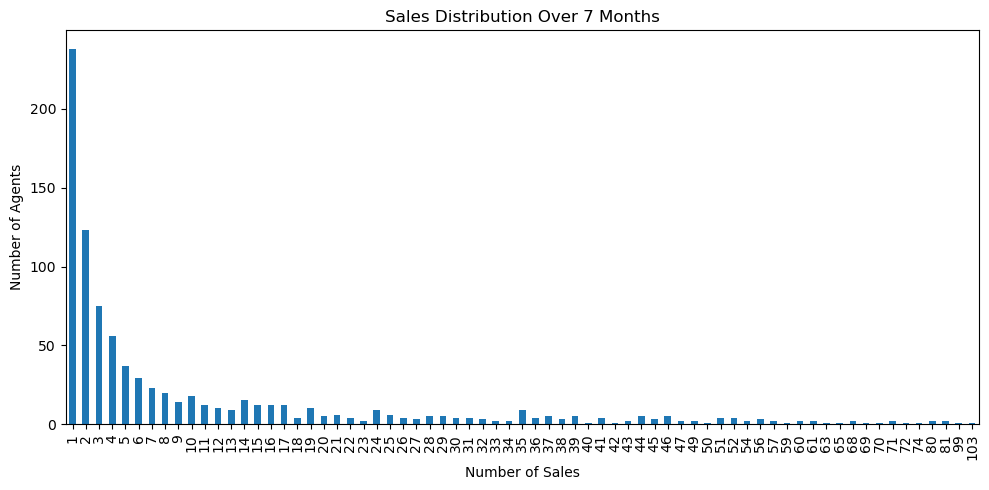

In [13]:
total_sales = df_sales_jan_jul.groupby('Login')['Sales Count'].sum()

# Sort in descending order — optional
total_sales = total_sales.sort_values(ascending=False)

# Count the number of each value
counts = total_sales.value_counts().sort_index()

# Build a histogram
plt.figure(figsize=(10, 5))
counts.plot(kind='bar')

plt.title('Sales Distribution Over 7 Months')
plt.xlabel('Number of Sales')
plt.ylabel('Number of Agents')
plt.tight_layout()
plt.show()

As shown in the chart, the vast majority of agents — **approximately 56% — made no more than 4 sales over the 7-month period**. This may indicate that a large portion of agents stopped working shortly after starting.

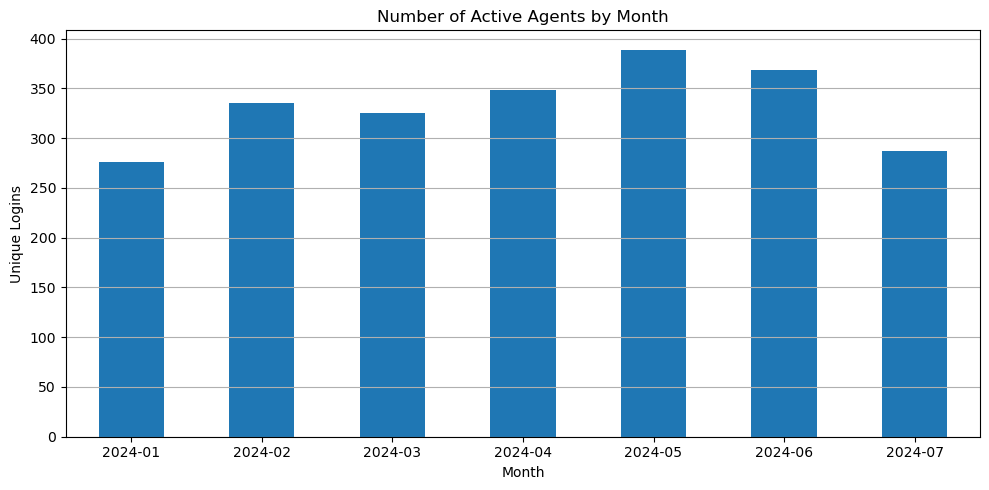

In [14]:
# Make sure the date column is in datetime format
df_sales_jan_jul['Ticket Issuing Date'] = pd.to_datetime(df_sales_jan_jul['Ticket Issuing Date'])

# Create a new column with the month in the format '2024-02' (YYYY-MM)
df_sales_jan_jul['Month'] = df_sales_jan_jul['Ticket Issuing Date'].dt.to_period('M').astype(str)

# Group by month and count unique Login
monthly_agent_counts = df_sales_jan_jul.groupby('Month')['Login'].nunique()

# Plot the graph
plt.figure(figsize=(10, 5))
monthly_agent_counts.plot(kind='bar')

plt.title('Number of Active Agents by Month')
plt.xlabel('Month')
plt.ylabel('Unique Logins')
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Until May, there was a relatively positive trend in the number of active agents, but from May to July, the number began to decline, especially noticeably from June to July.

It is likely that new employees tend to quit early, possibly due to the low number of leads they receive in the beginning. Let’s test this hypothesis by analyzing new agents from contracted_agents who signed contracts just before the sales_jan_jul period. We’ll examine how the average number of received leads changes based on months of employment.

In [15]:
# Get sets of logins
logins_contracted = set(df_contracted_agents.index)
logins_assigned = set(df_assigned_leads['Login'])

# Find the intersection
common_logins = logins_contracted & logins_assigned

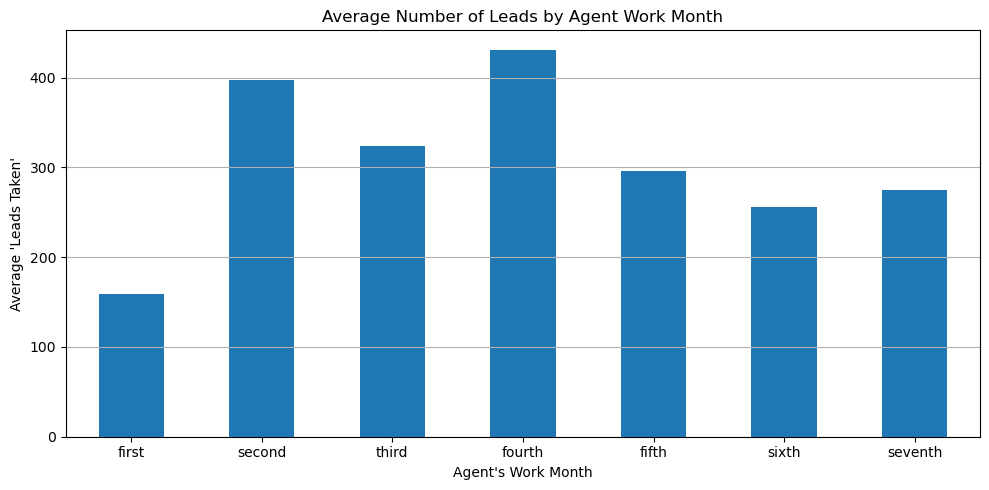

In [16]:
# 1. Filter only the required logins
filtered_df = df_assigned_leads[df_assigned_leads['Login'].isin(common_logins)].copy()

# 2. Make sure Assign Month is in datetime or at least in a sortable format
# If these are strings like '2024-03', convert to datetime
filtered_df['Assign Month'] = pd.to_datetime(filtered_df['Assign Month'], format='%Y-%m')

# 3. Sort the data
filtered_df.sort_values(['Login', 'Assign Month'], inplace=True)

# 4. Number the months for each agent — first month, second, etc.
filtered_df['Month Number'] = filtered_df.groupby('Login').cumcount() + 1

# 5. Group by month sequence number and calculate the average Leads Taken
avg_leads_by_month = filtered_df.groupby('Month Number')['Leads Taken'].mean()

# Replacement dictionary from numbers to text
month_order_labels = {
    1: 'first', 2: 'second', 3: 'third', 4: 'fourth',
    5: 'fifth', 6: 'sixth', 7: 'seventh'
}

# Rename Series indices (month number → text)
avg_leads_by_month_named = avg_leads_by_month.rename(index=month_order_labels)

# Build a histogram
plt.figure(figsize=(10, 5))
avg_leads_by_month_named.plot(kind='bar')

plt.title('Average Number of Leads by Agent Work Month')
plt.xlabel("Agent's Work Month")
plt.ylabel("Average 'Leads Taken'")
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


According to the data, **in their first month, agents receive on average 2 times fewer leads than in the following months**. This likely explains why nearly half of all agents quit after the first month. Below is a table showing how many months agents from contracted_agents stayed active.

In [17]:
pd.DataFrame(filtered_df['Month Number'].value_counts().sort_index()).T

Month Number,1,2,3,4,5,6,7
count,212,108,73,38,33,28,19


Out of 304 valid agents in contracted_agents, only 212 received leads to work with, according to the assigned_leads data. This means that about 30% of agents never started working despite signing a contract. All contracts were signed in December 2023 or January 2024, while the sales period covers the first 7 months of 2024. It is likely that these agents either were not given leads or refused to work after signing the contract. Let’s try to determine if there is any correlation between this and the time between application submission and contract signing (based on contracted_agents data).

In [56]:
df_contracted_agents['Application Date'] = pd.to_datetime(df_contracted_agents['Application Date'])
df_contracted_agents['Contract Date'] = pd.to_datetime(df_contracted_agents['Contract Date'])

# Calculate the difference in days
df_contracted_agents['Days to Contract'] = (df_contracted_agents['Contract Date'] - df_contracted_agents['Application Date']).dt.days

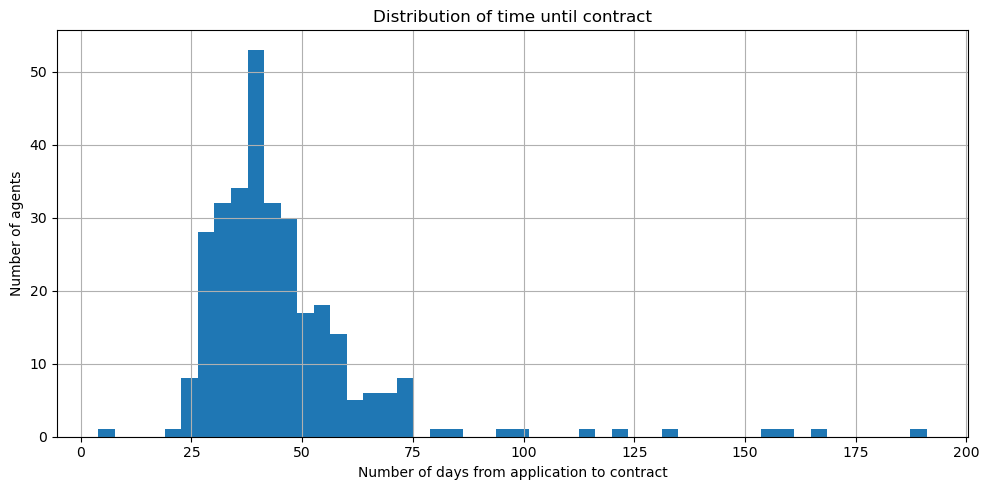

In [58]:
plt.figure(figsize=(10, 5))

# Build a histogram
df_contracted_agents['Days to Contract'].hist(bins=50)  # you can change bins for more detail

plt.title('Distribution of time until contract')
plt.xlabel('Number of days from application to contract')
plt.ylabel('Number of agents')
plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
exclusive_logins = logins_contracted - common_logins
# Convert set to list
exclusive_logins_list = list(exclusive_logins)

# Filter by indexes
filtered_days = df_contracted_agents.loc[exclusive_logins_list, 'Days to Contract']

# Count the occurrences of each value
day_counts = filtered_days.value_counts().sort_index()

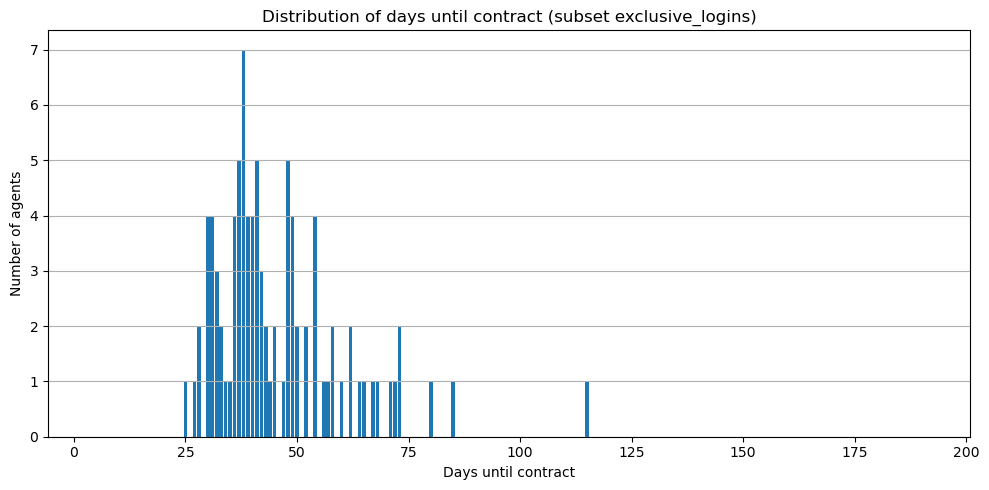

In [59]:
# All unique days from the entire column (sort them)
all_days = np.sort(df_contracted_agents['Days to Contract'].dropna().unique())

# For each day from all_days take the number from day_counts, if not present — 0
frequencies = [day_counts.get(day, 0) for day in all_days]

plt.figure(figsize=(10, 5))
plt.bar(all_days, frequencies)

plt.title('Distribution of days until contract (subset exclusive_logins)')
plt.xlabel('Days until contract')
plt.ylabel('Number of agents')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

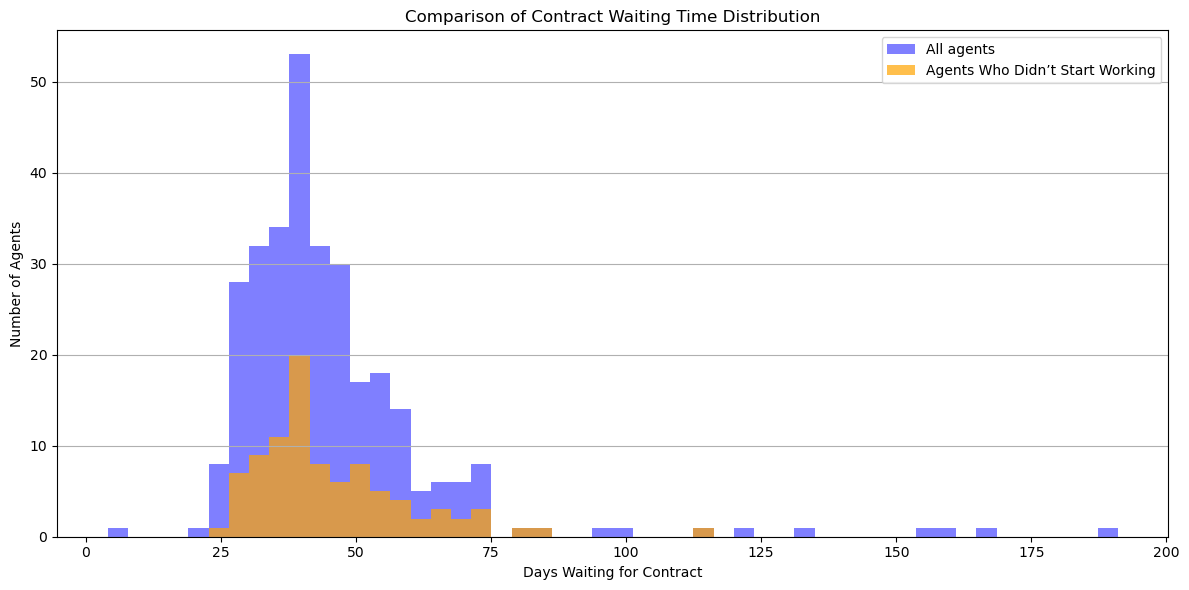

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Range and number of bins
min_day = df_contracted_agents['Days to Contract'].min()
max_day = df_contracted_agents['Days to Contract'].max()
bins = 50 

# 1. Get bins and frequencies for the entire dataset
counts_all, bin_edges = np.histogram(df_contracted_agents['Days to Contract'].dropna(), bins=bins, range=(min_day, max_day))

# 2. To calculate frequencies_subset with the same bins, we need to assign the days to the bins
# For this, we use np.digitize
days_subset = df_contracted_agents.loc[list(exclusive_logins), 'Days to Contract'].dropna()
bin_indices = np.digitize(days_subset, bins=bin_edges, right=False)

# Count the frequencies in the same bins for the subset
counts_subset = np.array([np.sum(bin_indices == i) for i in range(1, len(bin_edges))])

plt.figure(figsize=(12, 6))

# 3. Plot the histogram for the entire dataset
plt.bar(bin_edges[:-1], counts_all, width=np.diff(bin_edges)[0], alpha=0.5, label='All agents', color='blue', align='edge')

# 4. Plot the histogram for the subset
plt.bar(bin_edges[:-1], counts_subset, width=np.diff(bin_edges)[0], alpha=0.7, label='Agents Who Didn’t Start Working', color='orange', align='edge')

plt.title('Comparison of Contract Waiting Time Distribution')
plt.xlabel('Days Waiting for Contract')
plt.ylabel('Number of Agents')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Based on the distribution, there is no clear correlation: **the number of days between application and contract signing does not affect whether the agent received leads. There is also no dependency on ad source or education level — agents without leads are present across all groups**.

Let’s move on to a general analysis of the agent data.

In [26]:
pd.DataFrame(df_contracted_agents['Education Level'].value_counts()).T

Education Level,Bachelor,College,Masters,Professional,School,Doctorate
count,135,71,45,32,11,2


In [27]:
pd.DataFrame(df_contracted_agents['Country of Residence'].value_counts()).T

Country of Residence,India,Nigeria,Pakistan,Uzbekistan,Moldova
count,291,6,3,3,1


In [28]:
pd.DataFrame(df_contracted_agents['Source of Advertisement'].value_counts()).T

Source of Advertisement,facebook,Google,linkedin,HRM,DPTR,instagram_bio,indeed,fecebook_bot
count,151,126,9,8,4,2,2,2


We’ll review the summary data by agent and analyze how the average number of sales per person over 7 months varies depending on the ad source and education level. (The “Country of Residence” column is excluded from the analysis, as almost all agents are from India.)

In [48]:
bachelor_logins = df_contracted_agents[df_contracted_agents['Education Level'] == 'Bachelor'].index
filtered_sales_bachelor = df_sales_jan_jul[df_sales_jan_jul['Login'].isin(bachelor_logins)]
sales_bachelor_mean = filtered_sales_bachelor['Sales Count'].sum() / filtered_sales_bachelor['Login'].nunique()
sales_bachelor_mean = round(sales_bachelor_mean, 2)
sales_bachelor_mean

10.64

In [47]:
College_logins = df_contracted_agents[df_contracted_agents['Education Level'] == 'College'].index
filtered_sales_College = df_sales_jan_jul[df_sales_jan_jul['Login'].isin(College_logins)]
sales_College_mean = filtered_sales_College['Sales Count'].sum() / filtered_sales_College['Login'].nunique()
sales_College_mean = round(sales_College_mean, 2)
sales_College_mean

7.44

In [46]:
Masters_logins = df_contracted_agents[df_contracted_agents['Education Level'] == 'Masters'].index
filtered_sales_Masters = df_sales_jan_jul[df_sales_jan_jul['Login'].isin(Masters_logins)]
sales_Masters_mean = filtered_sales_Masters['Sales Count'].sum() / filtered_sales_Masters['Login'].nunique()
sales_Masters_mean = round(sales_Masters_mean, 2)
sales_Masters_mean

13.27

In [44]:
Professional_logins = df_contracted_agents[df_contracted_agents['Education Level'] == 'Professional'].index
filtered_sales_Professional = df_sales_jan_jul[df_sales_jan_jul['Login'].isin(Professional_logins)]
sales_Professional_mean = filtered_sales_Professional['Sales Count'].sum() / filtered_sales_Professional['Login'].nunique()
sales_Professional_mean = round(sales_Professional_mean, 2)
sales_Professional_mean

10.31

In [45]:
School_logins = df_contracted_agents[df_contracted_agents['Education Level'] == 'School'].index
filtered_sales_School = df_sales_jan_jul[df_sales_jan_jul['Login'].isin(School_logins)]
sales_School_mean = filtered_sales_School['Sales Count'].sum() / filtered_sales_School['Login'].nunique()
sales_School_mean = round(sales_School_mean, 2)
sales_School_mean

20.5

In [51]:
Doctorate_logins = df_contracted_agents[df_contracted_agents['Education Level'] == 'Doctorate'].index
filtered_sales_Doctorate = df_sales_jan_jul[df_sales_jan_jul['Login'].isin(Doctorate_logins)]
sales_Doctorate_mean = filtered_sales_Doctorate['Sales Count'].mean()
sales_Doctorate_mean

nan

In [35]:
df_mean_sales = pd.DataFrame({
    'Education Level': ['Bachelor', 'College', 'Masters', 'Professional', 'School', 'Doctorate'],
    'Average Sales': [
        sales_bachelor_mean,
        sales_College_mean,
        sales_Masters_mean,
        sales_Professional_mean,
        sales_School_mean,
        sales_Doctorate_mean
    ]
})

df_mean_sales = df_mean_sales.set_index('Education Level')
df_mean_sales.T

Education Level,Bachelor,College,Masters,Professional,School,Doctorate
Average Sales,10.64,7.44,13.27,10.31,20.5,NaN


In [53]:
facebook_logins = df_contracted_agents[df_contracted_agents['Source of Advertisement'] == 'facebook'].index
filtered_sales_facebook = df_sales_jan_jul[df_sales_jan_jul['Login'].isin(facebook_logins)]
sales_facebook_mean = filtered_sales_facebook['Sales Count'].sum() / filtered_sales_facebook['Login'].nunique()
sales_facebook_mean = round(sales_facebook_mean, 2)
sales_facebook_mean

12.12

In [54]:
Google_logins = df_contracted_agents[df_contracted_agents['Source of Advertisement'] == 'Google'].index
filtered_sales_Google = df_sales_jan_jul[df_sales_jan_jul['Login'].isin(Google_logins)]
sales_Google_mean = filtered_sales_Google['Sales Count'].sum() / filtered_sales_Google['Login'].nunique()
sales_Google_mean = round(sales_Google_mean, 2)
sales_Google_mean

9.3

In [138]:
df_mean_sales = pd.DataFrame({
    'Source of Advertisement': ['facebook', 'Google'],
    'Average Sales': [
        sales_facebook_mean,
        sales_Google_mean
    ]
})

df_mean_sales = df_mean_sales.set_index('Source of Advertisement')
df_mean_sales.T

Source of Advertisement,facebook,Google
Average Sales,12.12,9.3


In [52]:
print(filtered_sales_bachelor['Login'].nunique())
print(filtered_sales_College['Login'].nunique())
print(filtered_sales_Masters['Login'].nunique())
print(filtered_sales_Professional['Login'].nunique())
print(filtered_sales_School['Login'].nunique())
print(filtered_sales_Doctorate['Login'].nunique())

33
27
11
13
4
0


According to the data, **agents with the education level "School" show the highest average number of sales per person over 7 months. However, it’s important to note that there are only 4 such agents in the dataset, so the results may not be statistically stable. In the other groups, there is no clear relationship between sales volume and education level or ad source**.

In total: **out of 304 valid agents from contracted_agents, only 212 received leads, and just 93 of them made at least one sale**.

In [12]:
a = set(df_sales_jan_jul['Login'].unique())
b = set(df_contracted_agents.index)
c = set(df_assigned_leads['Login'].unique())
d = c & b
len(d)

212

### Key Points:

1. On average, each agent makes about 0.05 sales per day and earns 0.26 in daily profit.
2. There is a clear outlier — the row "va380, 2024-05" with a "Leads Taken" value of 4652.
3. None of the top 10 agents by sales are in the top 10 by received leads.
4. On average, 133 leads are needed to make one sale, which brings in $5 in profit (Total profit).
5. Approximately 56% of agents made no more than 4 sales over 7 months.
6. In their first month, agents receive on average 2 times fewer leads than in the following months.
7. The number of days between application and contract signing does not affect whether an agent received leads.
8. There is no dependency on ad source or education level — agents without leads are found in all groups.
9. Agents with the education level "School" show the highest average number of sales per person over 7 months. However, the sample size is only 4, so the result may not be statistically reliable.
10. In other groups, there is no clear link between sales volume and education or ad source.
11. Out of 304 valid agents in contracted_agents, only 212 received leads, and only 93 made at least one sale.

In [15]:
!jupyter nbconvert "The second part.ipynb" --to html --no-input --log-level=ERROR